In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.stattools import medcouple
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns

# home brew utitilties
import resources.utility_functions as ut
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex


# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-03-01'
end_date ='2021-05-31'

# name of the output folder:
name_of_project = 'threshold_values'

# the scale for pieces per meter and the column and chart label for the units
reporting_unit = 100
unit_label = 'p/100m'

# add the folder to the directory tree:
project_directory = ut.make_project_folder('output', name_of_project)

# get your data:
survey_data = pd.read_csv('resources/results_with_land_use_2015.csv')
river_bassins = ut.json_file_get("resources/river_basins.json")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfDims = pd.read_csv("resources/dims_data.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# map locations to feature names
location_wname_key = dfBeaches.water_name_slug

# map water_name_slug to water_name
wname_wname = dfBeaches[['water_name_slug','water_name']].reset_index(drop=True).drop_duplicates()
wname_wname.set_index('water_name_slug', inplace=True)

# convenience function for doing land use correlations
def make_plot_with_spearmans(data, ax, n):
    sns.scatterplot(data=data, x=n, y=unit_label, ax=ax, color='black', s=30, edgecolor='white', alpha=0.6)
    corr, a_p = stats.spearmanr(data[n], data[unit_label])
    return ax, corr, a_p

# index the code data
dfCodes.set_index("code", inplace=True)

# these descriptions need to be shortened for display
dfCodes = sut.shorten_the_value(["G74", "description", "Insulation: includes spray foams"], dfCodes)
dfCodes = sut.shorten_the_value(["G940", "description", "Foamed EVA for crafts and sports"], dfCodes)
dfCodes = sut.shorten_the_value(["G96", "description", "Sanitary-pads/tampons, applicators"], dfCodes)
dfCodes = sut.shorten_the_value(["G178", "description", "Metal bottle caps and lids"], dfCodes)
dfCodes = sut.shorten_the_value(["G82", "description", "Expanded foams 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G81", "description", "Expanded foams .5cm - 2.5cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G117", "description", "Expanded foams < 5mm"], dfCodes)
dfCodes = sut.shorten_the_value(["G75", "description", "Plastic/foamed polystyrene 0 - 2.5cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G76", "description", "Plastic/foamed polystyrene 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G24", "description", "Plastic lid rings"], dfCodes)
dfCodes = sut.shorten_the_value(["G33", "description", "Lids for togo drinks plastic"], dfCodes)
dfCodes = sut.shorten_the_value(["G3", "description", "Plastic bags, carier bags"], dfCodes)
dfCodes = sut.shorten_the_value(["G204", "description", "Bricks, pipes not plastic"], dfCodes)

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code descriptions
code_material_map = dfCodes.material

(threshhold)=
# Calculating beach litter baseline values

Baseline values (BVs), sometimes refered to as _benchmarks_, are the quantities or values that are used to define a situation statistically. The BVs refer to a set of data that has both temporal and geographical limits, some times refered to as a _reference point_ or _base line period_, BVs are the quantities against which progress is measured. In this regard, BVs are intimately linked to the data and the methods used to collect the data.

## Counting beach litter: an overview

The first international guide to collecting beach-litter data was published in 2008 by the United Nations Environment Programme (UNEP) and Intergovernmental Oceanographic Commission (IOC) {cite}`unepseas`. Based on the accumulated work of many scientists, this method was reproduced by the OSPAR Commission in 2010 {cite}`ospard10`, and in 2013 the EU released _Guidance on Monitoring of Marine Litter in European Seas_ (_the guide_) {cite}`mlwguidance`. Switzerland is a member of OSPAR and has over 1,500 samples using the methods described in _the guide_.

_The guide_ was followed by _Riverine Litter Monitoring - Options and Recommendations_ in 2016 {cite}`riverinemonitor`, reflecting the mounting evidence that rivers are important sources of household waste in coastal regions. By that time the initial beach litter surveillance project on Lac Léman had run its course and preparations were on the way for a year long national project in Switzerland initiated by STOPPP and supported by WWF volunteers, see [_More and less trash since 2017_](slr-iqaasl).

In 2019 the Joint Research Centre (JRC) released an _Analysis of a pan-European 2012-2016 beach litter dataset_ , a technical document that detailed the methods and different scenarios for calculating baseline values from beach litter data. Of particular interest to the JRC was the robustness of methods to extreme values and transparency of the calculation method. {cite}`eubaselines`

Finally, in September 2020 the EU established baseline and target values based on the data collected from 2015-2016. The target values relate to the Good Environmental Status of marine waters described by the Marine Strategy Framework Direvtive (MSFD) and the baselines were calculated using the methods described in the 2019 publication. {cite}`threshholdeu`

### Switzerland 2020

The IQAASL project started in April 2020, recycling many of the locations sampled in 2017 and establishing new locations through out the defined survey areas. Similar to survey results in the marine environment beach-litter-data in Switzerland is highly variable. With values ranging from zero to thousands of objects and fragments within 100m of river or lake shoreline.

## Calculating baselines

The methods described in sections 3 and 4 of _A European Threshold Value and Assessment Method for Macro Litter on Coastlines_ and {cite}`threshholdeu` are applied to the beach litter survey results from April 2020 to May 2021 collected durring IQAASL. The results are used to suggest improvements for the next sampling period and define baseline and extreme values for 2020 - 2021.

__Assumptions:__

*  The more trash there is on the ground the more a person is likely to find
*  **The survey results represent the minimum amount of trash at that site**
*  For each survey: finding one item does not effect the chance of finding another

### The data

Only surveys with a length greater than ten meters and less than 100 meters are included in the baseline calculation. The following objects were excluded:

1. Objects less than 2.5cm
2. Paraffin, wax, oil and other pollutants



In [2]:
# define the final survey data set here:
a_data = survey_data.copy()

# make a loc_date column from the survey data
# before converting to timestamp
a_data['loc_date']=tuple(zip(a_data.location, a_data.date))

# convert string dates from .csv to timestamp
a_data['date']=pd.to_datetime(a_data['date'], format='%Y-%m-%d')

# slice by start - end date
a_data = a_data[(a_data.date >= start_date)&(a_data.date <= end_date)]

# combine lugano and maggiore
# if the river bassin name does not equal tresa leave it, else change it to ticino
a_data['river_bassin'] = a_data.river_bassin.where(a_data.river_bassin != 'tresa', 'ticino' )

# assign the reporting value
a_data[unit_label] = (a_data.pcs_m * reporting_unit).round(2)

# scale the streets to kilometers
a_data['streets'] = a_data.streets.astype('int')
a_data['streets km'] = a_data.streets/1000

# save the data before aggregating to test
before_agg = a_data.copy()

# !! Remove the objects less than 2.5cm and chemicals !!
codes_todrop = ['G81', 'G78', 'G212', 'G213', 'G214']
a_data = a_data[~a_data.code.isin(codes_todrop)]

# use the code groups to get rid of all objects less than 5mm
a_data = a_data[a_data.groupname !=  'micro plastics (< 5mm)']
# !! 

# match records to survey data
fd_dims= dfDims[(dfDims.location.isin(a_data.location.unique()))&(dfDims.date >= start_date)&(dfDims.date <= end_date)].copy()

# make a loc_date column and get the unique values
fd_dims['loc_date'] = list(zip(fd_dims.location, fd_dims.date))

# map the survey area name to the dims data record
a_map = fd_dims[['loc_date', 'area']].set_index('loc_date')
l_map = fd_dims[['loc_date', 'length']].set_index('loc_date')

# map length and area from dims to survey data
for a_survey in fd_dims.loc_date.unique():
    a_data.loc[a_data.loc_date == a_survey, 'length'] = l_map.loc[[a_survey], 'length'][0]
    a_data.loc[a_data.loc_date == a_survey, 'area'] = a_map.loc[[a_survey], 'area'][0]

# exclude surveys less 10 meters or less
gten_lhun = a_data.loc[(a_data.length > 10)].copy()

# this is a common aggregation
agg_pcs_quantity = {unit_label:'sum', 'quantity':'sum'}

# survey totals by location
dt_all = gten_lhun.groupby(['loc_date','location','river_bassin', 'water_name_slug','date'], as_index=False).agg(agg_pcs_quantity)

*Survey results and summary statistics: samples greater than 10m and excluding objects less than 2.5cm and chemicals, n=371*

In [3]:
# bassin_map = PILImage.open("resources/maps/survey_locations_all.jpeg")

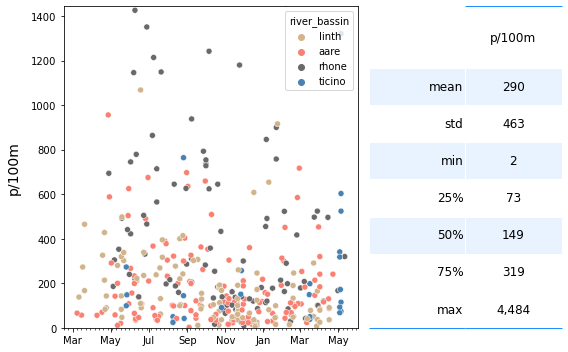

In [4]:
# palettes and labels
bassin_pallette = {'rhone':'dimgray', 'aare':'salmon', 'linth':'tan', 'ticino':'steelblue', 'reuss':'purple'}
comp_labels = {"linth":"Linth/Limmat", "rhone":"Rhône", 'aare':"Aare", "ticino":"Ticino/Cerisio", "reuss":"Reuss"}
comp_palette = {"Linth/Limmat":"dimgray", "Rhône":"tan", "Aare":"salmon", "Ticino/Cerisio":"steelblue", "Reuss":"purple"}

# months locator, can be confusing
# https://matplotlib.org/stable/api/dates_api.html
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
days = mdates.DayLocator(interval=7)

fig = plt.figure(figsize=(8,5))

gs = GridSpec(1,5)

ax = fig.add_subplot(gs[:,0:3])
axtwo = fig.add_subplot(gs[:, 3:])

# scale the chart as needed to accomodate for extreme values
scale_back = 98

# the results gets applied to the y_limit function in the chart
the_90th = np.percentile(dt_all[unit_label], scale_back)

# the survey totals
sns.scatterplot(data=dt_all, x='date', y=unit_label, hue='river_bassin', palette=bassin_pallette, alpha=1, ax=ax)

# set params on ax:
ax.set_ylim(0,the_90th )
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.set_xlabel("")
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)

# axtwo
a_color = "dodgerblue"

# summarize the survey totals and format for printing
table_data = dt_all[unit_label].describe()
table_data.drop('count', inplace=True)
table_data = table_data.astype('int')
table_data = table_data.map(lambda x: "{:,}".format(x))

# make a 2d array
t_data = list(zip(table_data.index, table_data.values))

data = t_data

ut.hide_spines_ticks_grids(axtwo)

the_first_table_data = axtwo.table(data,  colLabels=["Stat", unit_label], colWidths=[.5,.5], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data,["Stat", unit_label], a_color, s_et_bottom_row=True)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.tight_layout()
plt.show()
plt.close()

*Distribution of surveys and percentile ranking values: all surveys. Note the mean (290p/100m) is greater than the median (149p/100m)*

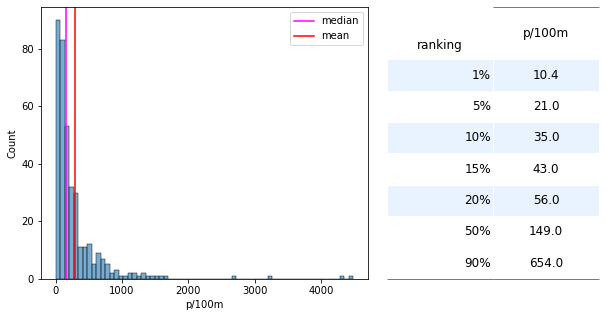

In [5]:
# percentile rankings  1, 5, 10, 15, 20
these_vals = []
for element in [.01,.05,.10,.15,.20, .5, .9 ]:
    a_val = np.quantile(dt_all[unit_label].to_numpy(), element)
    these_vals.append((F"{int(element*100)}%",a_val))

these_vals

fig = plt.figure(figsize=(10,5))

gs = GridSpec(1,5)

ax = fig.add_subplot(gs[:,0:3])
axtwo = fig.add_subplot(gs[:, 3:])

sns.histplot(data=dt_all, x=unit_label, stat='count', ax=ax, alpha=0.6)
ax.axvline(x=dt_all[unit_label].median(), c='magenta', label='median')
ax.axvline(x=dt_all[unit_label].mean(), c='red', label='mean')
ax.legend()


data = these_vals

ut.hide_spines_ticks_grids(axtwo)

the_first_table_data = axtwo.table(data,  colLabels=('ranking', unit_label), colWidths=[.5,.5], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data,('ranking', unit_label), a_color, s_et_bottom_row=True)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text("ranking")
plt.show()

### The assessment metric

Calculating baseline values requires the aggregatation of survey results at different temporal and geographic scales. The best method is the method that:

1. Is robust with respect to outliers
2. Simple to calculate
3. Widely understood

The two most common test statisics used to compare data is the mean and the median. The mean is the best predictor of central tendency if the data are $\approx$ normaly distributed. However that is not the case with beach litter survey results, generally skewed right with a long tail, beach litter suveys results have a high variance relative to the mean. There are methods that can be applied to the data to reduce the effects of outliers when calculating the mean:

1. _trimmed mean_: removes a small designated percentage of the largest and smallest values before calculating the mean
2. _tri mean_: the weighted average of the median and upper and lower quartiles, $(Q1 + 2Q2 + Q3)/4$.
3. _mid hinge: $(Q1 + Q3)/2$.

While effective at reducing the effects of the outliers, the previous methods are not as simple to calculate as the mean or the median and therfore the signficance of the results may not be well understood.

The median (50th percentile) is an equally good predictor of the central tendency but is much less effected by extreme values compared to the mean. The more a set of data approaches a normal distribution the more closely the median and mean approach. The _median_ and the accompanying  _percentile_ functions are available on most spreadsheet applications.

For the reasons cited previously, the median value of a minimum number of samples collected from a defined geographic area durring one sampling period is considered statistically and logistically suitable for beach litter assessments. For the marine environment the minumum number of samples is 40 per subregion and the sampling period is 6 years. {cite}`eubaselines` 

### Confidence intervals (CIs)

Confidence intervals (CIs) help communicate the uncertainty of beach-litter survey results with regards to any general conclusions that may be drawn about the abundance of beach litter within a region. The CI gives the lower and higher range of the estimate of the test statistic given the sample data. 

The best way to mitigate uncertainty is to have the appropriate number of samples for the region or area of interest. However beach litter surveys have a high variance and any estimate of an aggregate value should reflect that variance or uncertainty. CIs provide a probable range of values given the uncertainty/variance of the data.{cite}`eubaselines`

In this method data is NOT excluded from the baseline calculations and confidence intervals:

> It was agreed to leave the extreme data in the dataset, while highlighting the need to check to verify extreme data case by case and to apply the median for calculating of averages. This allows the use of all data while not skewing results through single extraordinary high litter count surveys. {cite}`threshholdeu`


#### Bootstrap methods:

Bootstrapping is a resampling method that uses random sampling with replacement to repeat or simulate the sampling process. Bootstrapping permits the estimation of the sampling distribution of sample statistics using random sampling methods. {cite}`bootstrapdef` {cite}`bsci` {cite}`usingbootstrap`

Bootstrap methods are used to calculate the CIs of the test statistics, by repeating the sampling process and evaluating the median at each repetition. The range of values described by the middle 95% of the bootstrap results is the CI for the observed test statisitic.

There are several computational methods to choose from such as percentile, BCa, and Student's t to name a few. For this example two methods were tested:

1. Percentile bootstrap
2. bias-corrected accelerated bootstrap confidence interval (BCa)

The _percentile method_ does not account for the _shape_ of the underlying distribution and this can lead to confidence intervals that do not match the data. The BCa corrects that. The implementation of these methods is straight forward using the previously cited packages. {cite}`bcatheory` {cite}`bcaimpdrysdale` {cite}`bcaconfidence`

### Comparing bootstrap CIs

*Confidence intervals calculated using the Percentile bootstrap method*

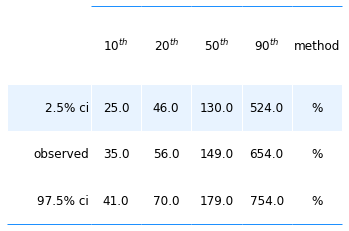

In [6]:
# bootstrap percentile confidence intervals
# the number of reps
n=5000

# keep the observed values
observed_median = dt_all[unit_label].median()
observed_tenth = dt_all[unit_label].quantile(.15)

quantiles = [.1, .2, .5, .9]
q_vals = {x:dt_all[unit_label].quantile(x) for x in quantiles}

the_cis = {}

for a_rank in quantiles:
    # place to keep the results from each resample

    # for the median
    sim_medians = []

    # for the tenth percentile
    sim_ten = []
    for element in np.arange(n):
        less = dt_all[unit_label].sample(n=len(dt_all), replace=True)    
        the_10th = less.quantile(a_rank)
        sim_ten.append(the_10th)
    # get the upper and lower range of the test statistic disrtribution:
    a_min = np.percentile(sim_ten, 2.5)
    a_max = np.percentile(sim_ten, 97.5)
    
    # add the observed value and update the dict
    the_cis.update({F"{int(a_rank*100)}":{'2.5% ci':a_min, 'observed': q_vals[a_rank], '97.5% ci': a_max}})

# make df
p_cis = pd.DataFrame(the_cis)
p_cis = p_cis.round(2)
p_cis['b-method'] = '%'
p_cis.reset_index(inplace=True)

fig, axs = plt.subplots()

data = p_cis.values
ut.hide_spines_ticks_grids(axs)

collabels = ["$" + F"{x}" +"^{th}$" for x in p_cis.columns[:-1]]
collabels.append('method')

the_first_table_data = axs.table(data, colLabels=collabels, colWidths=[.25,*[.15]*5], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data,collabels, a_color, s_et_bottom_row=True)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.close()

*Confidence intervals calculated using the BCa bootstrap method*

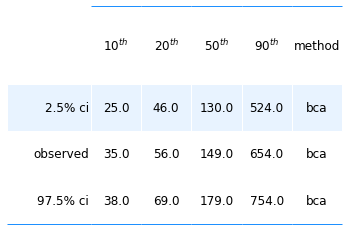

In [7]:
# this code was modified from this source:
# http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2019a/content/recitations/bootstrapping.html
# if you want to get the confidence interval around another point estimate use np.percentile
# and add the percentile value as a parameter

def draw_bs_sample(data):
    """Draw a bootstrap sample from a 1D data set."""
    return np.random.choice(data, size=len(data))

def compute_jackknife_reps(data, statfunction=None, stat_param=False):
    '''Returns jackknife resampled replicates for the given data and statistical function'''
    # Set up empty array to store jackknife replicates
    jack_reps = np.empty(len(data))

    # For each observation in the dataset, compute the statistical function on the sample
    # with that observation removed
    for i in range(len(data)):
        jack_sample = np.delete(data, i)
        if not stat_param:
            jack_reps[i] = statfunction(jack_sample)
        else:
            jack_reps[i] = statfunction(jack_sample, stat_param)          
        
    return jack_reps


def compute_a(jack_reps):
    '''Returns the acceleration constant a'''

    mean = np.mean(jack_reps)
    try:
        a = sum([(x**-(i+1)- (mean**-(i+1)))**3 for i,x in enumerate(jack_reps)])
        b = sum([(x**-(i+1)-mean-(i+1))**2 for i,x in enumerate(jack_reps)])
        c = 6*(b**(3/2))
        data = a/c
    except:
        print(mean)
    return data


def bootstrap_replicates(data, n_reps=1000, statfunction=None, stat_param=False):
    '''Computes n_reps number of bootstrap replicates for given data and statistical function'''
    boot_reps = np.empty(n_reps)
    for i in range(n_reps):
        if not stat_param:
            boot_reps[i] = statfunction(draw_bs_sample(data))
        else:
            boot_reps[i] = statfunction(draw_bs_sample(data), stat_param)     
        
    return boot_reps


def compute_z0(data, boot_reps, statfunction=None, stat_param=False):
    '''Computes z0 for given data and statistical function'''
    if not stat_param:
        s = statfunction(data)
    else:
        s = statfunction(data, stat_param)
    return stats.norm.ppf(np.sum(boot_reps < s) / len(boot_reps))


def compute_bca_ci(data, alpha_level, n_reps=1000, statfunction=None, stat_param=False):
    '''Returns BCa confidence interval for given data at given alpha level'''
    # Compute bootstrap and jackknife replicates
    boot_reps = bootstrap_replicates(data, n_reps, statfunction=statfunction, stat_param=stat_param)
    jack_reps = compute_jackknife_reps(data, statfunction=statfunction, stat_param=stat_param)

    # Compute a and z0
    a = compute_a(jack_reps)
    z0 = compute_z0(data, boot_reps, statfunction=statfunction, stat_param=stat_param)

    # Compute confidence interval indices
    alphas = np.array([alpha_level/2., 1-alpha_level/2.])
    zs = z0 + stats.norm.ppf(alphas).reshape(alphas.shape+(1,)*z0.ndim)
    avals = stats.norm.cdf(z0 + zs/(1-a*zs))
    ints = np.round((len(boot_reps)-1)*avals)
    ints = np.nan_to_num(ints).astype('int')

    # Compute confidence interval
    boot_reps = np.sort(boot_reps)
    ci_low = boot_reps[ints[0]]
    ci_high = boot_reps[ints[1]]
    return (ci_low, ci_high)

the_bcas = {}
for a_rank in quantiles:
    an_int = int(a_rank*100)
    a_result = compute_bca_ci(dt_all[unit_label].to_numpy(), .05, n_reps=5000, statfunction=np.percentile, stat_param=an_int)
    observed = np.percentile(dt_all[unit_label].to_numpy(), an_int)
    the_bcas.update({F"{int(a_rank*100)}":{'2.5% ci':a_result[0], 'observed': observed, '97.5% ci': a_result[1]}})

bca_cis = pd.DataFrame(the_bcas)
bca_cis['b-method'] = 'bca'
bcas = bca_cis.reset_index()

fig, axs = plt.subplots()

data = bcas.values
ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(data, colLabels=collabels, colWidths=[.25,*[.15]*5], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data,collabels, a_color, s_et_bottom_row=True)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.close()

### Base line values

For this set of data the differences between the CIs calculated the BCa method or the percentile method is minimum. The BCa method will be used to report the baseline values and CIs.

#### Baseline median value of all survey results

Considering only surveys with a length greater than 10 meters and excluding objects less than 2.5cm, the median survey result of all data was 149p/100m with a CI of 130p/100m - 179p/100m. The range of CI of the IQAASL survey results includes the estimated median value of the combined European dataset used to test these methods (149p/100m). While the median value may be greater in Switzerland the mean value from the EU study is 504p/100m versus 290p/100m in Switzerland.{cite}`eubaselines`

Suggesting that the EU data set has the higher extreme values but the expected median value from both data sets is similar.

#### Baseline median and CI per survey area

There were four survey areas in the IQAASL, 3 of which had more than 40 samples durring the SP. 

*The median and the 95% confidence interval of the Linth, Aare and Rhône survey areas. The Ticino survey area is not included for lack of a sufficient quantity of surveys.*

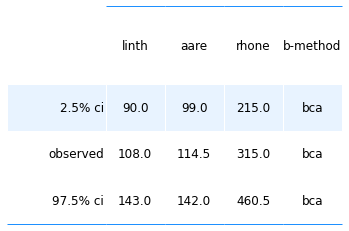

In [8]:
bassins = ["linth", "aare", "rhone"]
the_sas = {}
for a_bassin in bassins:
    an_int = int(a_rank*100)
    a_result = compute_bca_ci(dt_all[dt_all.river_bassin == a_bassin][unit_label].to_numpy(), .05, n_reps=5000, statfunction=np.percentile, stat_param=50)
    observed = np.percentile(dt_all[dt_all.river_bassin == a_bassin][unit_label].to_numpy(), 50)
    the_sas.update({a_bassin:{'2.5% ci':a_result[0], 'observed': observed, '97.5% ci': a_result[1]}})

sas = pd.DataFrame(the_sas)
sas['b-method'] = 'bca'
sas = sas.reset_index()

fig, axs = plt.subplots()

data = sas.values
ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(data, colLabels=sas.columns, colWidths=[.25,*[.15]*5], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data,sas.columns, a_color, s_et_bottom_row=True)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.close()

## Extreme values

As was noted earlier, extreme values or outliers are not excluded from the data when calculating baselines or CIs. However, identifying extreme values and where and when they occur is an essential part of the monitoring process.

The occurrence of extreme values can influence the average of the data and the interpretation of survey results. According to the JRC report:

>  The methodology for the identification of extreme values can be either expert judgement, or be based on statistical and modelling approaches, such as the application of Tukey’s box plots to detect potential outliers. For skewed distributions, the adjusted box plot is more appropriate. {cite}`eubaselines`

Boxplots are a method to locate extreme values based on the percentile ranking of the surveys. This method is compatible with the assessment metric and boxplots are fairly easy to resolve visually.

### Adjusted boxplots

Tukey’s boxplot is used to visualize the distribution of a univariate data set. The samples that fall within the first quartile ($Q_1$) and the third quartile ($Q_3$) are considered to be within the innerquartial range (IQR) = $Q_3 - Q_1$. Points out side of the inner quartile range are considered outliers if their value is greater or less than one of two limits:

* lower limit = $Q_1 - (1.5*IQR)$

* upper limit = $Q_3 + (1.5*IQR)$

Adusting the boxplot involves replacing the constant 1.5 with another parameter. This parameter is calculated using a method called the _medcouple_ (MC) and applying the result of that method to the constant 1.5. {cite}`adjbox` {cite}`medcouple` The new calculation looks like this:

* lower limit = $Q_1 - (1.5e^{-4MC}*IQR)$

* upper limit = $Q_3 + (1.5e^{3MC}*IQR)$

*The limit at which a survey is conisdered _extreme_ extends to the 98th percentile when the boxplots are adjusted as opposed to the 90th percentile if the constant is left at 1.5.*

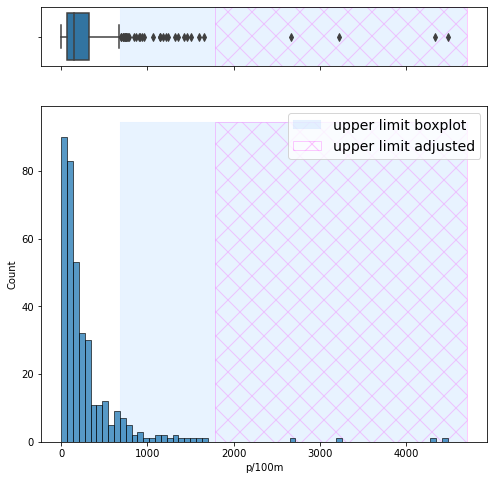

In [9]:
# implementation of medcouple
a_whis = medcouple(dt_all[unit_label].to_numpy())

# get the ecdf 
ecdf = ECDF(dt_all[unit_label].to_numpy())

# quantiles and IQR of the data
q1 = dt_all[unit_label].quantile(0.25)
q3 =dt_all[unit_label].quantile(0.75)
iqr = q3 - q1

# the upper and lower limit of extreme values unadjusted:
limit_lower = q1 - 1.5*iqr
limit_upper = q3 + 1.5*iqr

# the upper and lower limit of extreme values adjusted:
a_fence = q1 - (1.5*(math.exp((-4*a_whis))))*iqr
a_2fence = q3 + (1.5*(math.exp((3*a_whis))))*iqr

# source = https://stackoverflow.com/questions/12127635/matplotlib-can-we-draw-a-histogram-and-a-box-plot-on-a-same-chart
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8,8))

# Add a graph in each part
sns.boxplot(x=dt_all[unit_label], ax=ax_box)
sns.histplot(x=dt_all[unit_label], ax=ax_hist)

# get the limits of the x and y axix
xamax = ax_hist.get_xlim()
y_max= ax_hist.get_ylim()

# no xlabel on the top axis
ax_box.set_xlabel(" ")

# fill the areas concerened by each limt
ax_hist.fill_between(x=[limit_upper,xamax[1]], y1=y_max[1], label='upper limit boxplot', alpha=0.1, color="dodgerblue", linewidth=0.1)
ax_hist.fill_between(x=[a_2fence,xamax[1]], y1=y_max[1],label='upper limit adjusted', hatch='x', edgecolor='magenta', facecolor='none',alpha=0.2)

ax_box.fill_between(x=[limit_upper,xamax[1]], y1=ax_box.get_ylim()[1], y2=ax_box.get_ylim()[0],  label='upper limit boxplot', alpha=0.1, color="dodgerblue", linewidth=0.1)
ax_box.fill_between(x=[a_2fence,xamax[1]], y1=ax_box.get_ylim()[1], y2=ax_box.get_ylim()[0], label='upper limit adjusted', hatch='x', edgecolor='magenta', facecolor='none',alpha=0.2)

# get legend
handles, labels = ax_box.get_legend_handles_labels()
plt.legend(handles, labels, fontsize=14)

plt.show()

In [10]:
caption = F"""
*The difference between adjusted and normal boxplots. Adjusted = {int(a_2fence)} {unit_label},  unadjusted = {int(limit_upper)} {unit_label}.*
"""
md(caption)


*The difference between adjusted and normal boxplots. Adjusted = 1784 p/100m,  unadjusted = 687 p/100m.*


Using the adjusted boxplots pushes the extreme value threshold (EVT) to over 1600p/100m. However the unadjusted boxplots are very close to the expected $90{th}$ percentile of the survey data.

### Modeling

Extreme values can be identified by assuming the data belong to some underlying known statistical distribution. In general count data are assumed to be Poisson distributed with mean = varaince. The data from IQAASL and beach-litter data in general do not meet this criteria, the variance is usually greater than the mean. The negative binomial (NB2) distribution allows for this. {cite}`cameron` {cite}`wolfram`

> The modelling approach for the identification of extreme values is then performed by fitting the NB-distribution to the data by means of maximum likelihood and tagging all values in the right tail as potentially extreme values if the probability that they belong to the fitted NB-distribution is less than, e.g. 0.001. {cite}`threshholdeu`

#### NB method of moments

Modeling data is a vast domain and many fields and industries have developed specific algorythms using parameters from known relationships. The techniques from the MSFD are for greater temporal and spatial ranges than those defined by the IQAASL. The purpose of modeling for this example is to simply identify probable extreme values of aggregated data, a generalist approach by definition.

Fitting the NB distribution has all to do with estimating parameters, _maximum likelihood estimation_ can be an involved process. The method of moments produces comparable results and the parameters can be taken from the data {cite}`mlenb` {cite}`nbinom` {cite}`examplemmoments`.  

The ratio of distributed objects to contributed objects is used to parametrize the distribution, see ([_Asessing transport_](transport) for details. There are several basic statistical packages that cover this use, the examples here and elsewhere in this publication come from SciPy and statsmodels. {cite}`2020SciPy` {cite}`medcouple` 

*Estimating the parameters of the underlying NB distribution using the mean and the variance from the observed values* 

*implementation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.nbinom.html*

2070.0 3199.984156517351


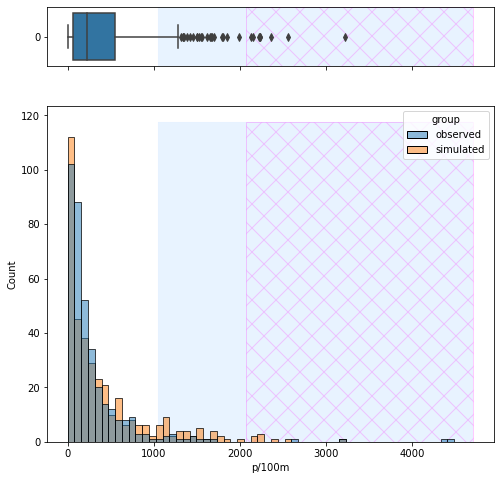

In [11]:
# the data to model
vals = dt_all[unit_label].to_numpy()

# whiskers for the boxplots
a_whis = medcouple(vals)

# the ratio of distributed items to contributed items in rural locations:
# see the assessing transport notebook for a complete epxlanation
dispersion_param = 1.7*.8

# the variance
var = np.var(vals)

# the average
mean = np.mean(vals)

# dispersion
p = (mean/var)
n = (mean**2/(var-mean))*dispersion_param

# point estimates from for the 98 and 90 %ile
rv = stats.nbinom(n, p)
sim_98 = rv.ppf(.98)
obs_98 = np.quantile(vals, .98)

sim_90 = rv.ppf(.9)
obs_90 = np.quantile(vals, .9)

# simulated data
r = stats.nbinom.rvs(n,p, size=len(vals))
a_whis = medcouple(r)

# quantiles and IQR of the data
q1 = np.percentile(r, 25)
q3 =np.percentile(r,75)
iqr = q3 - q1

# the upper and lower limit of extreme values unadjusted:
limit_lower = q1 - 1.5*iqr
limit_upper = q3 + 1.5*iqr

# the upper and lower limit of extreme values adjusted:
a_fence = q1 - (1.5*(math.exp((-4*a_whis))))*iqr
a_2fence = q3 + (1.5*(math.exp((3*a_whis))))*iqr

print(sim_98, a_2fence)

# format data for charting
df = pd.DataFrame({unit_label:vals, 'group':'observed'})
df = df.append(pd.DataFrame({unit_label:r, 'group':'simulated'}))

fig, (axone, axtwo) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8,8))

# Add a graph in each part
sns.boxplot(data=df[df.group == 'simulated'][unit_label], orient='h',ax=axone)
sns.histplot(data=df, x=unit_label, hue='group', stat='count', multiple="layer", legend=True, ax=axtwo)

# get the limits of the x and y axis
xamax = axtwo.get_xlim()
y_max= axtwo.get_ylim()

# no xlabel on the top axis
axone.set_xlabel(" ")

# fill the areas concerened by each limit
axtwo.fill_between(x=[sim_90,xamax[1]], y1=y_max[1], label='lower limit simulated', alpha=0.1, color="dodgerblue", linewidth=0.1)
axtwo.fill_between(x=[sim_98,xamax[1]], y1=y_max[1],label='upper limit simulated', hatch='x', edgecolor='magenta', facecolor='none',alpha=0.2)

axone.fill_between(x=[sim_90,xamax[1]], y1=axone.get_ylim()[1], y2=axone.get_ylim()[0],  label='upper limit boxplot', alpha=0.1, color="dodgerblue", linewidth=0.1)
axone.fill_between(x=[sim_98,xamax[1]], y1=axone.get_ylim()[1], y2=axone.get_ylim()[0], label='upper limit adjusted', hatch='x', edgecolor='magenta', facecolor='none',alpha=0.2)

plt.show()

In [12]:
caption = F"""
*Point estimate of the 98th percentile from simulated data = {int(sim_98)} {unit_label}, estimate of the 90th percentile = {int(sim_90)} {unit_label}*
"""
md(caption)


*Point estimate of the 98th percentile from simulated data = 2070 p/100m, estimate of the 90th percentile = 1053 p/100m*


In [23]:
import statsmodels.distributions.discrete as distr
from statsmodels.discrete.discrete_model import NegativeBinomialP, Poisson, GeneralizedPoisson
from statsmodels.discrete.count_model import (ZeroInflatedNegativeBinomialP, ZeroInflatedPoisson,
                                              ZeroInflatedGeneralizedPoisson)
import statsmodels.discrete._diagnostics_count as dia

In [41]:
# expected_params = [1, 1, 0.5]
# np.random.seed(987123)
# nobs = 500
# exog = np.ones((nobs, 2))
# exog[:nobs//2, 1] = 0
# # offset is used to create misspecification of the model
# # for predicted probabilities conditional moment test
# #offset = 0.5 * np.random.randn(nobs)
# range_mix = 0.5
# offset = -range_mix / 2 + range_mix * np.random.rand(nobs)
# offset = 0
# mu_true = np.exp(exog.dot(expected_params[:-1]) + offset)
# prob_infl = 0.15
# # endog = distr.zinegbin.rvs(mu_true, expected_params[-1],
# #                            2, prob_infl, size=mu_true.shape)



In [67]:
endog = dt_all[unit_label].to_numpy()
exog = [1]*len(endog)


In [68]:
model_nb = NegativeBinomialP(endog, exog, p=2)
res_nb = model_nb.fit( maxiter=5000, maxfun=5000)

Optimization terminated successfully.
         Current function value: 6.665874
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9


In [57]:
res_nb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomialP Regression Results                     
==============================================================================
Dep. Variable:                      y   No. Observations:                  371
Model:              NegativeBinomialP   Df Residuals:                      370
Method:                           MLE   Df Model:                            0
Date:                Mon, 23 Aug 2021   Pseudo R-squ.:               4.516e-13
Time:                        13:20:21   Log-Likelihood:                -2473.0
converged:                       True   LL-Null:                       -2473.0
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6703      0.056    101.961      0.000       5.561       5.779
alpha          1.1439      0.074     15.561      0.000       1.000       1.288
==============================================================================
"""

In [59]:
res_nb.mle_settings

{'optimizer': 'bfgs',
 'start_params': array([5.67027122, 2.55271018]),
 'maxiter': 5000,
 'full_output': 1,
 'disp': 1,
 'fargs': (),
 'callback': <function statsmodels.discrete.discrete_model.NegativeBinomialP.fit.<locals>.<lambda>(*x)>,
 'retall': False,
 'maxfun': 5000,
 'extra_fit_funcs': {},
 'gtol': 1e-05,
 'norm': inf,
 'epsilon': 1.4901161193847656e-08}

In [65]:
res_nb.bic

4957.911199807004

In [74]:
p

0.001352121000613608

<AxesSubplot:ylabel='Count'>

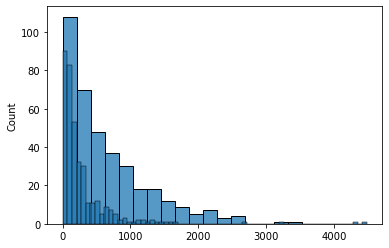

In [79]:
from scipy.stats import gamma
# r = gamma.rvs(1.1438, size=385)
r = stats.nbinom.rvs(1,p, size=len(vals))
sns.histplot(r)
sns.histplot(vals)

In [66]:
import statsmodels.discrete.discrete_model.NegativeBinomial as nbl

ModuleNotFoundError: No module named 'statsmodels.discrete.discrete_model.NegativeBinomial'; 'statsmodels.discrete.discrete_model' is not a package

In [60]:
dir(res_nb)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_get_endog_name',
 '_get_robustcov_results',
 '_use_t',
 'aic',
 'bic',
 'bse',
 'conf_int',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'f_test',
 'fittedvalues',
 'get_margeff',
 'initialize',
 'k_constant',
 'llf',
 'llnull',
 'llr',
 'llr_pvalue',
 'lnalpha',
 'lnalpha_std_err',
 'load',
 'mle_retvals',
 'mle_settings',
 'model',
 'nobs',
 'normalized_cov_params',
 'params',
 'predict',
 'prsquared',
 'pvalues',
 'remove_data',
 'resid',
 'resid_response',
 'save',
 'scale',
 'set_null_options',
 'summary',
 'summary2',
 't_test',
 

In [54]:

probs_nb = res_nb.predict(which='prob')
probsm_nb = probs_nb.mean(0)




AttributeError: 'NegativeBinomialResults' object has no attribute 'pdf'

In [50]:
len(probsm_nb)

4485

In [52]:
probs_nb[0][:10]

array([0.0062388 , 0.00543739, 0.00507998, 0.00485229, 0.00468553,
       0.00455389, 0.004445  , 0.00435198, 0.00427066, 0.0041983 ])

## Discussion

The adoption of a standard measuring system and evaluation method is an important development. This allows for standardized analysis accross geographical regions and aggregation levels. Stakeholders now have an objective measurement and a method to measure.

* aggregate groups can ba analysed across regions

* one time events can be compared to regional baselines

This allows policy makers to measure the effects of current and past mitigation strategies. This report and the manner in which it was produced is one benefit of standardization.

### Thresholds

The European Union has set a european wide threshold value of $\approx$ 20p/100m based on data collected in 2015-2016. This value is based on the $15^{th}$ percentile of the 2015-2016 results. In Switzerland the $15^{th}$ percentile is between 39 and 53 p/100m for 2020-2021.

### Number of samples

The recomended number of samples is by area of analysis. For an adequate analysis of a single body of water then the number of samples should be comensurate with the size and samples should be taken throughout the sampling period. However, individual results can be compared directly to baseline values for the region of interest. That is a direct benefit of using the median survey result.

### Extreme values

The exact method to define an extreme value should be evaluated. In this article we used the EU methods because they are applicable for a larger geographic scale. Regional and municipal stakeholders most likely have specific knowledge that can explain extreme results much more efficiently than a model.

While modeling of the data and expected results is an interesting and challenging field it is NOT a prerequisite for defining extreme values. If there are enough samples then the extreme value can be set off the percentile rank of the current data set for the region of interest. Practically speaking this means that there should be enough samples and those samples need to be distributed geographically within a survey area such that individual surveys can be compared directly to the regional results.

This simplifies the assessment of individual surveys by local leaders. Thus empowering them to address the chalenges directly and in coordination with other stakeholders in the region.

### Quality people = quality data

The quality of the data is directly related to the training and support of the surveyors. The identification process is long at first and many objects that are encountered are not part of an _average persons_ day. Encouraging meetings between surveyors and having a core team to assisst in the development and training ensures that the surveys are conducted consistently over time.

The surveyors are also responsible for data integrity and analysis of a survey area or multiple survey areas. This implies that the surveyors need to have or need to develop the skills required to gather, analyze and present the data using the standardized methods.

### Objective criteria , analysis and communication

The data gathered during IQASL, SLR and the EU data from 2015-2016 are all compatible. This is because they were all based on the same protocol and that protocol **was designed to gather data as accurately as possible given limited resources and a large geographic area**. The same reasoning should apply to the analysis and communication of results, cost effective and broad based. A consistent and objective analysis is the best communication tool and should be addresed to municipal leaders, cantonal authorities and NGOS in the field.

Municipalities and regional NGOS usually have well developed communication methods. These results allow leaders to put the global problem in a local context with results from locations that the population is familiar with, that are in some instances just down the street.

> There is a difference in urgency of action if you tell someone that a building 50km away is burining or the neighbors house is burning.

The importance of this is often overlooked and has repercussions with respect to ressource allocation and prioritization of mitigation and attenuation strategies.

In [13]:
author = "roger@hammerdirt.ch"
my_message = "Love what you do. \u2764\ufe0f"
md(F"""
<br></br>
**This project was made possible by the Swiss federal office for the environment.**<br>

>{my_message}<br>

*{author}* pushed the run button on {today}.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>
""")


<br></br>
**This project was made possible by the Swiss federal office for the environment.**<br>

>Love what you do. ❤️<br>

*roger@hammerdirt.ch* pushed the run button on 2021-08-23.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>
